In [1]:
from dataclasses import dataclass

import numpy as np
import deepxde as dde

from project.gen_data import gen_data
from project.post_processing import Plotter

# Problem parameters:
@dataclass
class PinnConstParam:
    a = 0.4 # Thermal diffusivity
    L = 1 # Length of the bar, Assum x starts at 0
    n = 1 # Frequency of the sinusoidal initial conditions
    t_end = 1 # Assume t_start  = 0
    test_x_dim = 100
    test_t_dim = 100

@dataclass
class PinnTestParam:
    d_num_domain = 2540
    d_num_boundary = 80
    d_num_initial = 160
    nn_hidden_layer_size = 20
    nn_hidden_layer_num = 3

def pde(x, y):
    """
    Expresses the PDE residual of the heat equation.        
    """
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - const_params.a*dy_xx

def create_model_and_train(const_params: PinnConstParam, test_params: PinnTestParam):
    # Computational geometry:
    geom = dde.geometry.Interval(0, const_params.L)
    timedomain = dde.geometry.TimeDomain(0, const_params.t_end)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)

    # Initial and boundary conditions:
    bc = dde.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
    ic = dde.IC(
        geomtime, lambda x: np.sin(const_params.n*np.pi*x[:, 0:1]/const_params.L) , lambda _, on_initial: on_initial
        )

    data = dde.data.TimePDE(
        geomtime, pde, [bc, ic], 
        num_domain=test_params.d_num_domain,
        num_boundary=test_params.d_num_boundary,
        num_initial=test_params.d_num_initial,
        num_test=2540
    )

    nn_architecture = [2] + [test_params.nn_hidden_layer_size] * test_params.nn_hidden_layer_num + [1]
    net = dde.nn.FNN(
        nn_architecture, 
        "tanh", 
        "Glorot normal")

    model = dde.Model(data, net)

    # Build and train the model:
    model.compile("adam", lr=1e-3)
    model.train(epochs=20000)
    model.compile("L-BFGS")
    losshistory, train_state = model.train()

    return data, model, losshistory, train_state

def plot_train_data(geomtime_data):
    X_bc_train = geomtime_data.bc_points()
    print("train_bc_points shape", X_bc_train.shape)

    plotter = Plotter(1, 2)
    plotter.plot_2d(X_bc_train, "train_bc_points")

    # Train points are not used anymore because deepxde train_points(), 
    # always generate random train points, but it is not what we are doing to
    # train the nn, in train_next_batch(). train_next_batch, isnt random!! 
    # X_train_points = geomtime_data.train_points()
    # print("train_points shape", X_train_points.shape)
    # plotter.plot_2d(X_train_points, "train_domain_points")

    X_train_next_batch, _, _ = geomtime_data.train_next_batch()
    print("train_next_batch shape", X_train_next_batch.shape)
    plotter.plot_2d(X_train_next_batch, "train_next_batch")

def predict_and_output_report(X_test, y_true, model, losshistory = None, train_state = None):
    # Analytical test solution
    plotter = Plotter(1, 2)

    plotter.plot_2d_y(X_test, y_true, "Analytical solution")

    # Physics Informed Neural Network test solution``
    y_pred = model.predict(X_test)
    plotter.plot_2d_y(X_test, y_pred, "PINN prediction")

    # Train loss, and Test data from PDE test data
    if losshistory and train_state:
        dde.saveplot(losshistory, train_state, issave=False, isplot=True)
    print("IGNORE ^^^ PDE test data SOLUTION PLOT!!! ^^^")

    f = model.predict(X_test, operator=pde)
    print("Mean residual:", np.mean(np.absolute(f)))
    print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
    # np.savetxt("test.dat", np.hstack((X_test, y_true, y_pred)))

# Generate constants throughout this app!!
const_params = PinnConstParam()
  
X_test, y_true = gen_data(
    "heat_1d_boundary_sin_exact",
    {
        "x_range": (0, const_params.L),
        "t_range": (0, const_params.t_end),
        "x_dim": const_params.test_x_dim,
        "t_dim": const_params.test_t_dim, 
        "a_coeff": const_params.a,
        "frequency": const_params.n,
    })


Using backend: tensorflow.compat.v1

2021-12-08 14:43:19.089349: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Instructions for updating:
non-resource variables are not supported in the long term






# Test 1: Default parameters from DeepXde

In [2]:
geomtime_data, model, losshistory, train_state = create_model_and_train(const_params, PinnTestParam())

Compiling model...
Building feed-forward neural network...
'build' took 0.032978 s



/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2542=2542. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+162=162. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/legacy_

'compile' took 0.229582 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [5.38e-03, 1.48e-02, 6.26e-01]    [5.91e-03, 1.48e-02, 6.26e-01]    []  


2021-12-08 14:43:25.669159: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
2021-12-08 14:43:25.689362: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3593295000 Hz


1000      [1.59e-03, 8.58e-04, 5.64e-04]    [1.01e-03, 8.58e-04, 5.64e-04]    []  
2000      [2.52e-04, 3.65e-05, 3.14e-05]    [1.52e-04, 3.65e-05, 3.14e-05]    []  
3000      [1.35e-04, 1.44e-05, 1.46e-05]    [8.91e-05, 1.44e-05, 1.46e-05]    []  
4000      [9.55e-05, 1.03e-05, 5.01e-06]    [6.55e-05, 1.03e-05, 5.01e-06]    []  
5000      [7.18e-05, 8.13e-06, 3.17e-06]    [4.92e-05, 8.13e-06, 3.17e-06]    []  
6000      [5.93e-05, 1.12e-05, 6.04e-06]    [4.16e-05, 1.12e-05, 6.04e-06]    []  
7000      [4.49e-05, 5.47e-06, 2.08e-06]    [3.10e-05, 5.47e-06, 2.08e-06]    []  
8000      [3.63e-05, 5.56e-06, 3.13e-06]    [2.55e-05, 5.56e-06, 3.13e-06]    []  
9000      [2.96e-05, 3.51e-06, 1.85e-06]    [2.09e-05, 3.51e-06, 1.85e-06]    []  
10000     [2.42e-05, 2.82e-06, 1.35e-06]    [1.72e-05, 2.82e-06, 1.35e-06]    []  
11000     [2.10e-05, 2.01e-06, 1.93e-06]    [1.51e-05, 2.01e-06, 1.93e-06]    []  
12000     [6.42e-05, 1.91e-05, 3.25e-06]    [5.27e-05, 1.91e-05, 3.25e-06]    []  
1300

train_bc_points shape (240, 2)
train_next_batch shape (3020, 2)


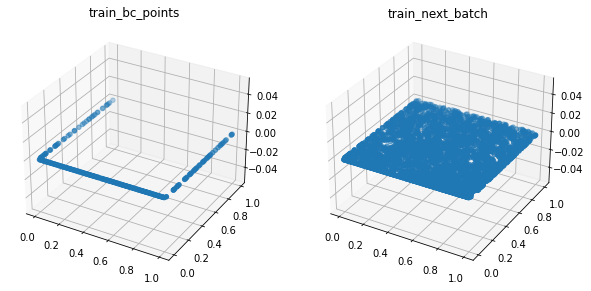

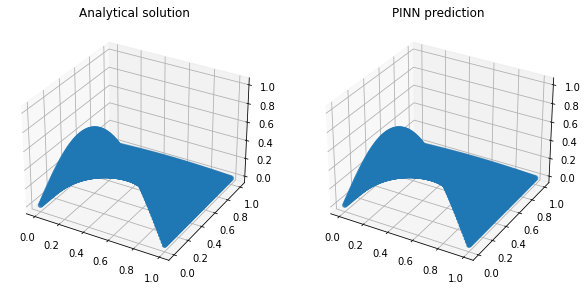

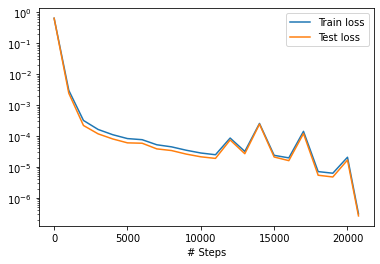

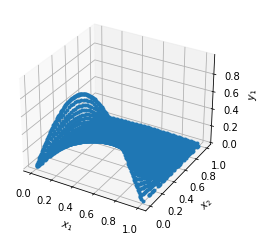

IGNORE ^^^ PDE test data SOLUTION PLOT!!! ^^^
Mean residual: 0.0003402131
L2 relative error: 0.0005533711179851639


In [4]:
plot_train_data(geomtime_data)
predict_and_output_report(X_test, y_true, model, losshistory, train_state)


# Test 2: Reduce hidden layers and size to break solution

In [2]:
test_params = PinnTestParam()
test_params.nn_hidden_layer_num = 1
test_params.nn_hidden_layer_size = 5

geomtime_data, model, losshistory, train_state = create_model_and_train(const_params, test_params)

Compiling model...
Building feed-forward neural network...
'build' took 0.017726 s



/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2542=2542. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+162=162. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/legacy_

'compile' took 0.158491 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.21e-01, 9.36e-02, 7.44e-01]    [4.20e-01, 9.36e-02, 7.44e-01]    []  


2021-12-08 14:14:48.781349: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
2021-12-08 14:14:48.799957: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3593295000 Hz


1000      [1.40e-02, 7.73e-02, 1.56e-01]    [1.30e-02, 7.73e-02, 1.56e-01]    []  
2000      [2.29e-02, 3.95e-02, 7.85e-02]    [2.00e-02, 3.95e-02, 7.85e-02]    []  
3000      [2.06e-02, 3.56e-02, 6.66e-02]    [1.77e-02, 3.56e-02, 6.66e-02]    []  
4000      [1.71e-02, 3.03e-02, 5.54e-02]    [1.48e-02, 3.03e-02, 5.54e-02]    []  
5000      [1.64e-02, 2.45e-02, 4.55e-02]    [1.44e-02, 2.45e-02, 4.55e-02]    []  
6000      [1.27e-02, 1.74e-02, 3.17e-02]    [9.97e-03, 1.74e-02, 3.17e-02]    []  
7000      [1.46e-02, 8.26e-03, 2.01e-02]    [1.18e-02, 8.26e-03, 2.01e-02]    []  
8000      [1.39e-02, 6.05e-03, 1.70e-02]    [1.13e-02, 6.05e-03, 1.70e-02]    []  
9000      [1.15e-02, 4.17e-03, 1.19e-02]    [8.64e-03, 4.17e-03, 1.19e-02]    []  
10000     [1.11e-02, 2.90e-03, 9.39e-03]    [8.08e-03, 2.90e-03, 9.39e-03]    []  
11000     [1.05e-02, 2.25e-03, 8.04e-03]    [7.63e-03, 2.25e-03, 8.04e-03]    []  
12000     [9.97e-03, 1.81e-03, 7.00e-03]    [7.20e-03, 1.81e-03, 7.00e-03]    []  
1300

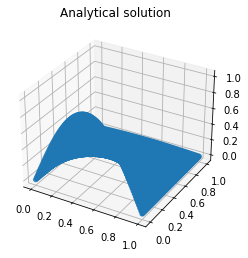

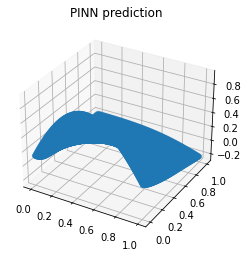

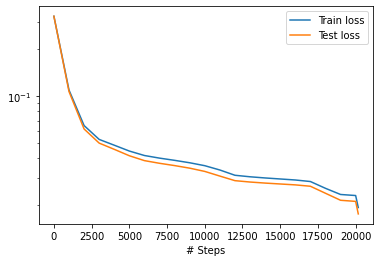

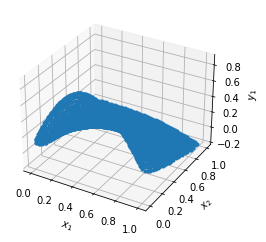

Mean residual: 0.06890949
L2 relative error: 0.19788800052300648


In [54]:
predict_and_output_report(X_test, y_true, model, losshistory, train_state)

# Test 3: Reduce boundary points to break solution

In [5]:
test_params = PinnTestParam()
test_params.d_num_boundary = 5
test_params.d_num_initial = 3

geomtime_data, model, losshistory, train_state = create_model_and_train(const_params, test_params)

Compiling model...
Building feed-forward neural network...
'build' took 0.028576 s



/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2542=2542. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+7=7. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+5=5. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_lay

'compile' took 0.208311 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.83e-02, 1.50e-02, 5.85e-01]    [2.77e-02, 1.50e-02, 5.85e-01]    []  
1000      [4.65e-04, 6.76e-05, 1.43e-03]    [4.04e-04, 6.76e-05, 1.43e-03]    []  
2000      [1.67e-04, 4.29e-05, 8.77e-04]    [1.24e-04, 4.29e-05, 8.77e-04]    []  
3000      [2.39e-04, 1.90e-05, 4.41e-04]    [1.85e-04, 1.90e-05, 4.41e-04]    []  
4000      [1.80e-04, 6.58e-06, 1.85e-04]    [1.32e-04, 6.58e-06, 1.85e-04]    []  
5000      [8.88e-05, 9.22e-07, 3.82e-05]    [6.06e-05, 9.22e-07, 3.82e-05]    []  
6000      [5.49e-05, 3.80e-07, 8.45e-06]    [3.98e-05, 3.80e-07, 8.45e-06]    []  
7000      [3.79e-05, 4.96e-07, 3.61e-06]    [2.83e-05, 4.96e-07, 3.61e-06]    []  
8000      [2.84e-05, 5.71e-07, 1.99e-06]    [2.17e-05, 5.71e-07, 1.99e-06]    []  
9000      [3.10e-05, 2.96e-05, 2.61e-05]    [2.65e-05, 2.96e-05, 2.61e-05]    []  
10000   

train_bc_points shape (8, 2)
train_next_batch shape (2556, 2)


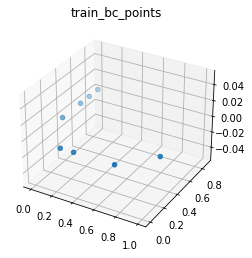

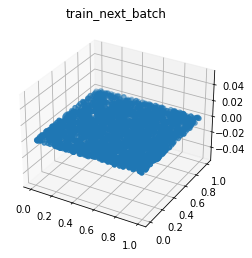

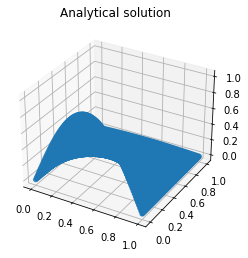

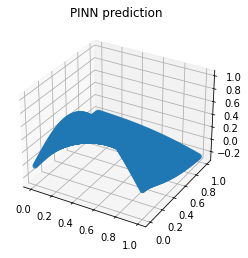

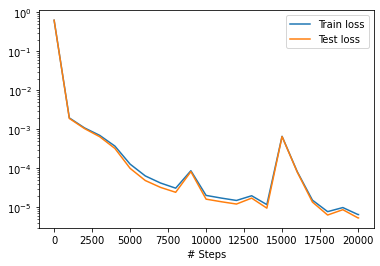

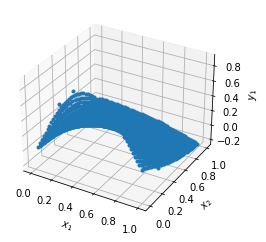

Mean residual: 0.0019329306
L2 relative error: 0.2677112808988169


In [6]:
plot_train_data(geomtime_data)
predict_and_output_report(X_test, y_true, model, losshistory, train_state)

# Test 4: Reduce domain to break solution

In [57]:
test_params = PinnTestParam()
test_params.d_num_domain = 50

geomtime_data, model, losshistory, train_state = create_model_and_train(const_params, test_params)

Compiling model...
Building feed-forward neural network...
'build' took 0.028116 s



/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+52=52. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+162=162. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_l

'compile' took 0.429690 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [5.50e-01, 1.22e-01, 2.50e-01]    [4.92e-01, 1.22e-01, 2.50e-01]    []  
1000      [3.37e-03, 2.92e-03, 3.48e-03]    [8.04e-03, 2.92e-03, 3.48e-03]    []  
2000      [7.25e-04, 2.57e-04, 2.76e-04]    [1.33e-03, 2.57e-04, 2.76e-04]    []  
3000      [2.61e-04, 1.77e-04, 1.33e-04]    [4.40e-04, 1.77e-04, 1.33e-04]    []  
4000      [1.33e-04, 1.11e-04, 7.88e-05]    [3.06e-04, 1.11e-04, 7.88e-05]    []  
5000      [2.34e-04, 9.33e-05, 5.74e-05]    [3.11e-04, 9.33e-05, 5.74e-05]    []  
6000      [6.42e-05, 6.71e-05, 5.12e-05]    [2.36e-04, 6.71e-05, 5.12e-05]    []  
7000      [4.81e-05, 2.85e-05, 1.78e-05]    [1.88e-04, 2.85e-05, 1.78e-05]    []  
8000      [4.18e-05, 2.11e-05, 1.20e-05]    [1.67e-04, 2.11e-05, 1.20e-05]    []  
9000      [3.73e-05, 1.63e-05, 8.83e-06]    [1.53e-04, 1.63e-05, 8.83e-06]    []  
10000   

train_bc_points shape (240, 2)
train_next_batch shape (530, 2)


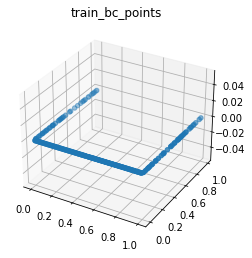

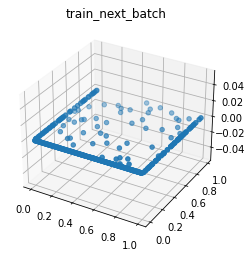

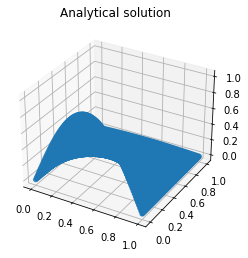

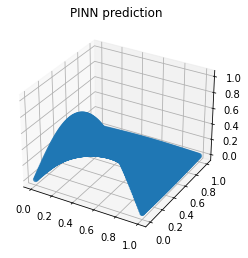

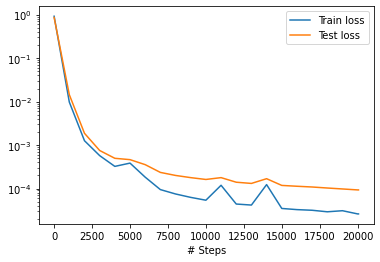

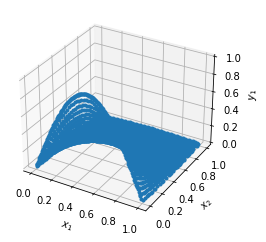

Mean residual: 0.007113696
L2 relative error: 0.005670521350935891


In [58]:
plot_train_data(geomtime_data)
predict_and_output_report(X_test, y_true, model, losshistory, train_state)

# Test 5: Reduce train data (domain and bc) to break solution

In [59]:
test_params = PinnTestParam()
test_params.d_num_domain = 50
test_params.d_num_boundary = 10
test_params.d_num_initial = 10

geomtime_data, model, losshistory, train_state = create_model_and_train(const_params, test_params)

Compiling model...
Building feed-forward neural network...
'build' took 0.030629 s



/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+52=52. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+12=12. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/base

'compile' took 0.809846 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.80e-01, 6.81e-02, 3.96e-01]    [2.70e-01, 6.81e-02, 3.96e-01]    []  
1000      [1.14e-03, 1.51e-03, 1.76e-03]    [1.42e-03, 1.51e-03, 1.76e-03]    []  
2000      [3.13e-04, 3.06e-04, 4.65e-05]    [7.93e-04, 3.06e-04, 4.65e-05]    []  
3000      [8.88e-05, 1.07e-04, 6.63e-06]    [6.47e-04, 1.07e-04, 6.63e-06]    []  
4000      [5.22e-05, 3.91e-05, 2.68e-06]    [4.00e-04, 3.91e-05, 2.68e-06]    []  
5000      [2.94e-05, 1.06e-05, 6.42e-06]    [2.09e-04, 1.06e-05, 6.42e-06]    []  
6000      [1.75e-05, 4.12e-06, 7.54e-07]    [1.34e-04, 4.12e-06, 7.54e-07]    []  
7000      [1.49e-05, 3.37e-06, 2.64e-06]    [1.04e-04, 3.37e-06, 2.64e-06]    []  
8000      [1.08e-05, 1.79e-06, 3.33e-07]    [8.33e-05, 1.79e-06, 3.33e-07]    []  
9000      [1.30e-05, 3.11e-06, 5.05e-06]    [7.39e-05, 3.11e-06, 5.05e-06]    []  
10000   

train_bc_points shape (20, 2)
train_next_batch shape (90, 2)


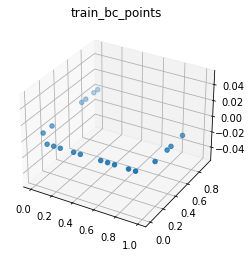

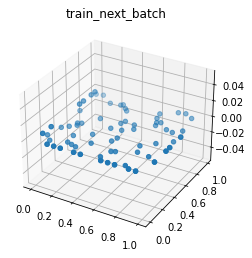

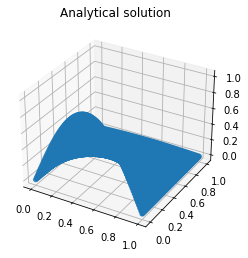

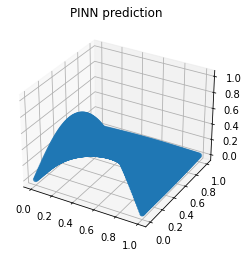

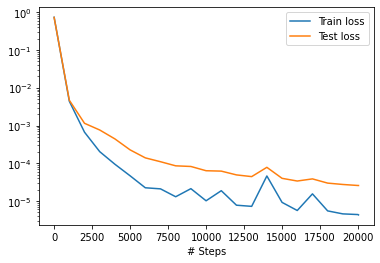

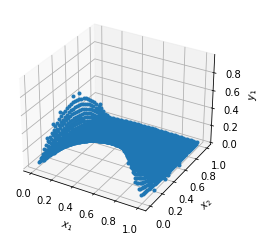

Mean residual: 0.0031376851
L2 relative error: 0.006621632730106989


In [60]:
plot_train_data(geomtime_data)
predict_and_output_report(X_test, y_true, model, losshistory, train_state)